In [194]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["font.size"] = 14

plt.rcParams.update({'mathtext.default':  'regular' })


In [2]:
def ff(x,omega, alpha):
    if alpha==0:
        return omega
    else:
        return omega/(x**(-alpha)+1.e-6)


def calc_score(itau, dt, itfms, omega, q, sigma2, alpha):
    expt = np.exp(-dt*(itfms-itau))
    exp2t = expt**2
    gammat = (sigma2*exp2t+1-exp2t)
    tanh = np.tanh(q*expt/gammat)
    nonlinear = (expt/gammat)*(1+(1 - np.tanh(q*expt/gammat)) *
                               ff((expt/gammat)*(1-tanh), omega, alpha))  # K: fixed, divided by gammat
    # Norm of S_full-S_class # this is what is added in cfg
    normdiff = (expt/gammat)*(1-tanh)
    return nonlinear, normdiff

def init_backward():
    return np.random.normal(0,1)
    
def calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha):
    qback = np.zeros(nt)
    time = np.zeros(nt)
    normd = np.zeros(nt)
    qback[0] = qinit
    q = qback[0]
    time[0] = 0
    for it in np.arange(nt-1):
        expt = np.exp(-dt*(itfms-it))
        exp2t = expt**2
        gammat = (sigma2*exp2t+1-exp2t)
        eta = np.random.normal(0, np.sqrt(2*dt))
        sc, normdiff = calc_score(it, dt, itfms, omega, q, sigma2, alpha)
        q = q-dt*q*(2/gammat-1)+2*dt*sc+eta
        qback[it+1] = q
        time[it+1] = it*dt
        normd[it] = normdiff
    return time, qback, normd

# Prelim plots

In [3]:
from tqdm import tqdm
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
dim=2
sigma2=1
alpha = -0.5

tspec=(1/2)*np.log(dim)
ns=int(tspec/dt)
print("Speciation time is: ", ns)
#ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))
for ijk in tqdm(np.arange(nsample)):
    qinit=init_backward()
    for iomega in np.arange(nomega):
        omega=4*iomega
        omegag[iomega]=omega
        time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)

Speciation time is:  34


 56%|█████▌    | 56/100 [00:03<00:02, 16.95it/s]

100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


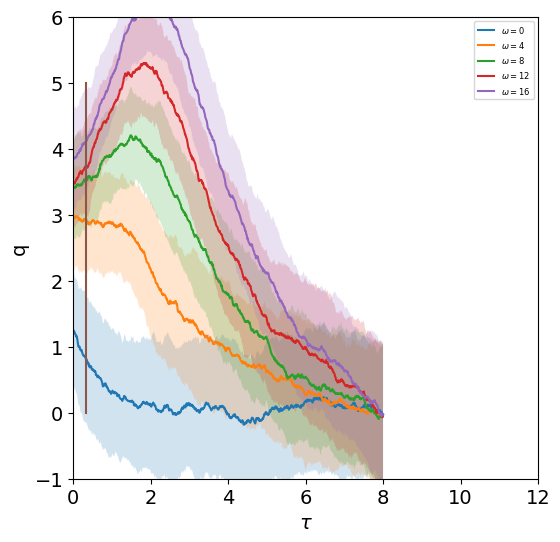

In [4]:
# cmap = plt.get_cmap('bwr')
# Plot data
qav=np.mean(qtraj,axis=1)
qstd = np.std(qtraj, axis=1)
for iomega in np.arange(nomega):
    plt.plot(nt*dt-time, qav[iomega,:], label=f'$\omega={4*iomega}$')
    plt.fill_between(nt*dt-time, qav[iomega,:]-qstd[iomega,:], qav[iomega,:]+qstd[iomega,:], alpha=0.2)
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,5])
plt.xlabel(r'$\tau$')
plt.ylabel('q')
plt.axis([0,12,-1,6])
plt.legend(fontsize=6)
plt.show()

# 1. Histograms for first plot - SAVED

In [17]:
from tqdm import tqdm
#Run nsample trajectories 
nsample=1000
dt=.01
nt=800 #final time is nt*dt
dim=2
sigma2=1
alpha = -0.5

tspec=(1/2)*np.log(dim)
ns=int(tspec/dt)
print("Speciation time is: ", ns)
#ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
omegas=[0., .2, 15.]
qtraj_low_dim=np.zeros((3,nsample,nt))
for ijk in tqdm(np.arange(nsample)):
    qinit=init_backward()
    for iomega in np.arange(3):
        omega=omegas[iomega]
        time,qtraj_low_dim[iomega,ijk,:],_=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)
dim=200
sigma2=1
alpha = -0.5

tspec=(1/2)*np.log(dim)
ns=int(tspec/dt)
print("Speciation time is: ", ns)
#ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
omegas=[0., 1., 15.]
qtraj_high_dim=np.zeros((3,nsample,nt))
for ijk in tqdm(np.arange(nsample)):
    qinit=init_backward()
    for iomega in np.arange(3):
        omega=omegas[iomega]
        time,qtraj_high_dim[iomega,ijk,:],_=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)

Speciation time is:  34


100%|██████████| 1000/1000 [00:34<00:00, 28.82it/s]


Speciation time is:  264


100%|██████████| 1000/1000 [00:34<00:00, 29.15it/s]


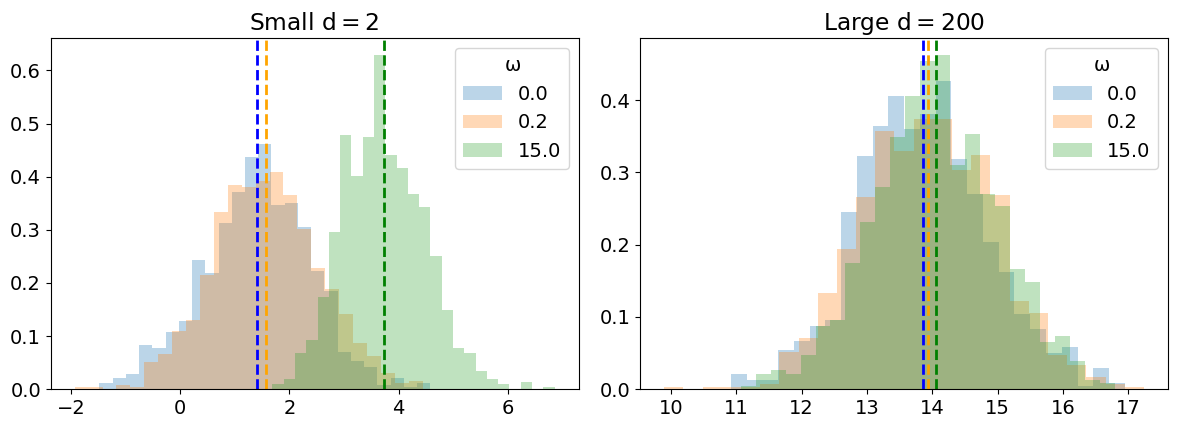

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
omegas = [0., .2, 15.]

axes[0].hist(qtraj_low_dim[0,:,-1], bins=25, alpha=0.3, density=True, label=omegas[0])
axes[0].hist(qtraj_low_dim[1,:,-1], bins=25, alpha=0.3, density=True, label=omegas[1])
axes[0].hist(qtraj_low_dim[-1,:,-1], bins=25, alpha=0.3, density=True, label=omegas[2])
axes[0].axvline(x=qtraj_low_dim[0,:,-1].mean(), color='blue', linestyle='dashed', linewidth=2)
axes[0].axvline(x=qtraj_low_dim[1,:,-1].mean(), color='orange', linestyle='dashed', linewidth=2)
axes[0].axvline(x=qtraj_low_dim[-1,:,-1].mean(), color='green', linestyle='dashed', linewidth=2)
axes[0].set_title(f'Small $d=2$')
axes[0].legend(title='$\omega$')


axes[1].hist(qtraj_high_dim[0,:,-1], bins=25, alpha=0.3, density=True, label=omegas[0])
axes[1].hist(qtraj_high_dim[1,:,-1], bins=25, alpha=0.3, density=True, label=omegas[1])
axes[1].hist(qtraj_high_dim[-1,:,-1], bins=25, alpha=0.3, density=True, label=omegas[2])
axes[1].axvline(x=qtraj_high_dim[0,:,-1].mean(), color='blue', linestyle='dashed', linewidth=2)
axes[1].axvline(x=qtraj_high_dim[1,:,-1].mean(), color='orange', linestyle='dashed', linewidth=2)
axes[1].axvline(x=qtraj_high_dim[-1,:,-1].mean(), color='green', linestyle='dashed', linewidth=2)
axes[1].set_title(f'Large $d=200$')
axes[1].legend(title='$\omega$')
# plt.suptitle('Generated samples for varying dimension $d$ and guid. param. $\omega$')
plt.tight_layout()
plt.savefig('new_figs/1_histograms.pdf')
plt.show()

# Differnce in score norms for different alpas - DONE

In [37]:
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
dim=200
sigma2=1

tspec=(1/2)*np.log(dim)
ns=int(tspec/dt)
print("Speciation time is: ", ns)
#ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))

alphas = [0., -0.75, -0.25, 0.25, 0.5, 0.75]

all_scores = []
for i, alpha in tqdm(enumerate(alphas)):
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)
    normav=np.mean(normstat,axis=1)
    all_scores.append(normav)
    

Speciation time is:  264


3it [00:17,  5.74s/it]/tmp/ipykernel_1744895/63343652.py:5: RuntimeWarning: divide by zero encountered in scalar power
  return omega/(x**(-alpha)+1.e-6)
6it [00:34,  5.80s/it]


/tmp/ipykernel_1744895/3562501572.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10, loc='upper left')


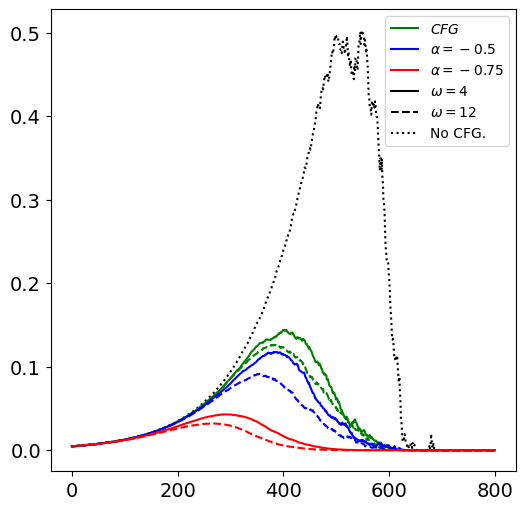

In [97]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
wtp = np.array(all_scores)[:3, :4, :]
plt.plot(wtp[0, 0, :].T, color='black', linestyle=':')
for i, c, l1 in zip([0,2,1], ['green', 'blue', 'red'], [0, 0.5, 0.75]):
    for j, ls, l2 in zip([2,3], ['-', '--'], [4, 12]):
        plt.plot(wtp[i, j, :].T, linestyle=ls, color=c)#, label=f'$\\alpha={l1}, \omega={l2}$')
# put it on the left part
plt.legend(fontsize=10, loc='upper left')


# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend

l1 = Line2D([0], [0], label=f'$CFG$', color='green')
l2 = Line2D([0], [0], label=f'$\\alpha=-0.5$', color='blue')
l3 = Line2D([0], [0], label=f'$\\alpha=-0.75$', color='red')
l4 = Line2D([0], [0], label=f'$\omega=4$', color='black', linestyle='-')
l5 = Line2D([0], [0], label=f'$\omega=12$', color='black', linestyle='--')
l6 = Line2D([0], [0], label=f'No CFG.', color='black', linestyle=':')


# add manual symbols to auto legend
handles.extend([l1, l2, l3, l4, l5, l6])

plt.legend(handles=handles, fontsize=10)

Speciation time is:  264


0it [00:00, ?it/s]

3it [00:16,  5.56s/it]/tmp/ipykernel_1744895/63343652.py:5: RuntimeWarning: divide by zero encountered in scalar power
  return omega/(x**(-alpha)+1.e-6)
6it [00:34,  5.69s/it]


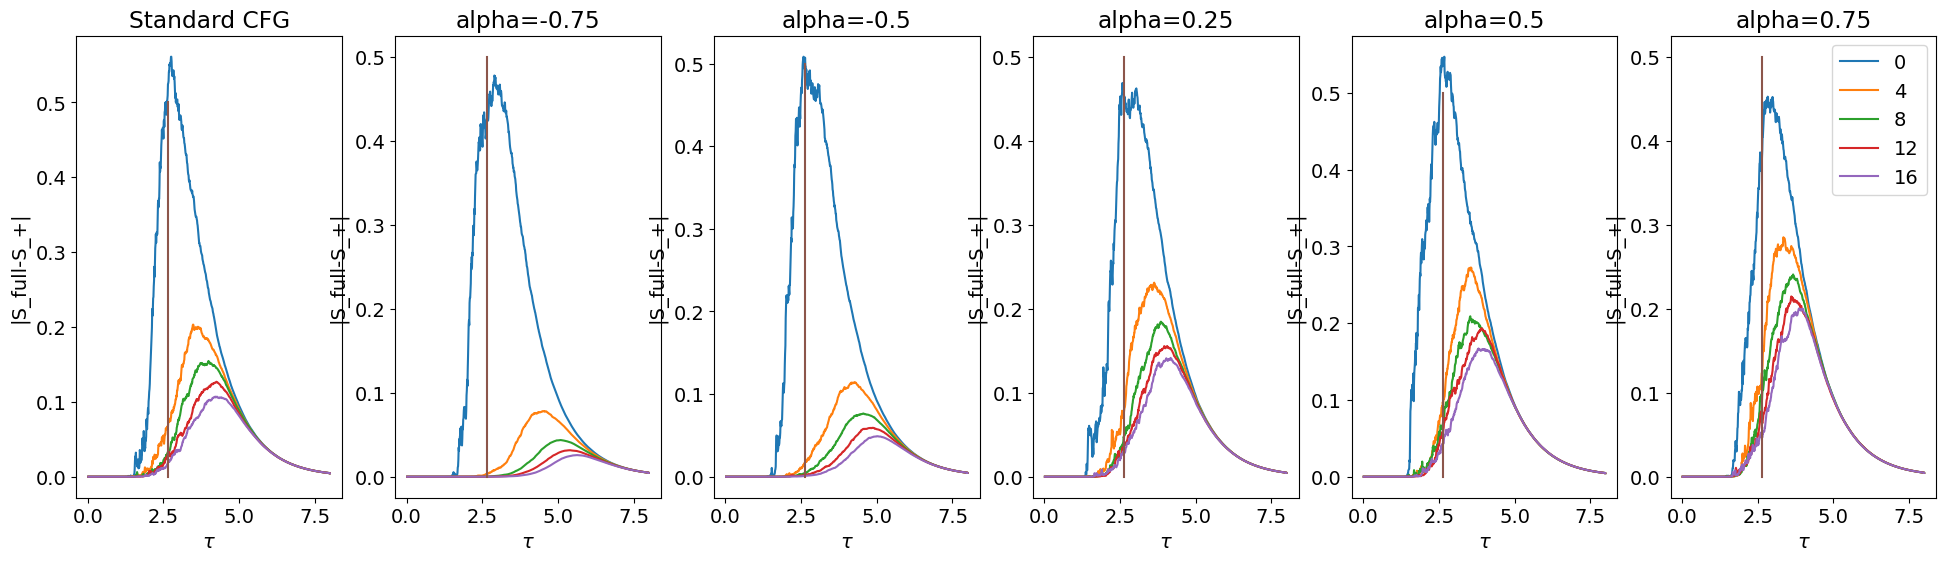

In [ ]:
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
dim=200
sigma2=1

tspec=(1/2)*np.log(dim)
ns=int(tspec/dt)
print("Speciation time is: ", ns)
#ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))

alphas = [0., -0.75, -0.5, 0.25, 0.5, 0.75]
fig, axes = plt.subplots(1, len(alphas), figsize=(24, 6))

for i, alpha in tqdm(enumerate(alphas)):
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)
    normav=np.mean(normstat,axis=1)
    for iomega in np.arange(nomega):
        axes[i].plot(nt*dt-time,normav[iomega,:], label=iomega*4)
    axes[i].plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,.5])
    axes[i].set_xlabel(r'$\tau$')
    axes[i].set_ylabel('|S_full-S_+|')
    axes[i].set_title(f'alpha={alpha}' if i !=0 else 'Standard CFG')
plt.legend()
plt.show()

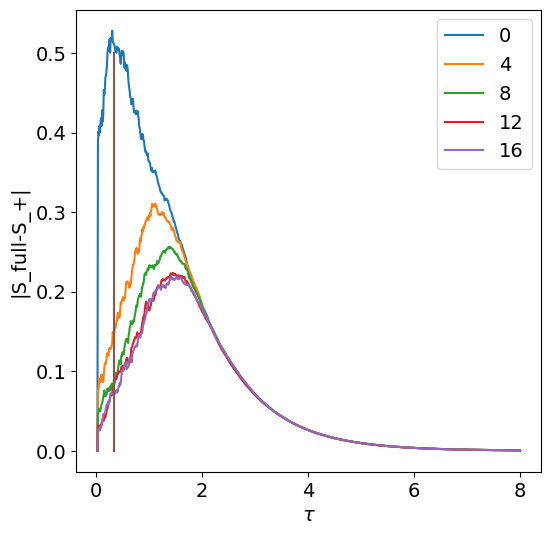

In [ ]:
# this is cfg - conditional, ends up being cond - unconditional cuz of the formula
# here u want to show two things: 1. as the dim increases the diff gets smaller
# 2. if we tune alpha we can always be closer to cond score -> plot diff to uncond as a proof that we get faster from the bulk of the data

# 2. CFG is really in regime 1 - SAVED


In [217]:
def calc_traj_back_change_score(qinit,nt,dt,itfms,omega,sigma2, alpha, change_at_spec=0): 
    qback = np.zeros(nt)
    time = np.zeros(nt)
    normd = np.zeros(nt)
    qback[0] = qinit
    q = qback[0]
    time[0] = 0
    for it in np.arange(nt-1):
        expt = np.exp(-dt*(itfms-it))
        exp2t = expt**2
        gammat = (sigma2*exp2t+1-exp2t)
        eta = np.random.normal(0, np.sqrt(2*dt))
        sc, normdiff = calc_score(it, dt, itfms, omega if it<change_at_spec else -omega, q, sigma2, alpha)
        q = q-dt*q*(2/gammat-1)+2*dt*sc+eta
        qback[it+1] = q
        time[it+1] = it*dt
        normd[it] = normdiff
    return time, qback, normd

In [218]:
from tqdm import tqdm
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
dim=10000
sigma2=1
alpha=0.

tspec=(1/2)*np.log(dim)
ns=int(tspec/dt)
print("Speciation time is: ", ns)
# ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
nomega=5
omegag=np.zeros(nomega)
qtraj_spec, qtraj_stand, qtraj_early, qtraj_earliest=np.zeros((nomega,nsample,nt)),np.zeros((nomega,nsample,nt)), np.zeros((nomega,nsample,nt)), np.zeros((nomega,nsample,nt))
normstat_spec, normstat_stand, normstat_early, normstat_earliest=np.zeros((nomega,nsample,nt)), np.zeros((nomega,nsample,nt)), np.zeros((nomega,nsample,nt)), np.zeros((nomega,nsample,nt))
for ijk in tqdm(np.arange(nsample)):
    qinit=init_backward()
    for iomega in np.arange(nomega):
        omega=4*iomega
        omegag[iomega]=omega
        time,qtraj_spec[iomega,ijk,:],normstat_spec[iomega,ijk,:]=calc_traj_back_change_score(qinit,nt,dt,itfms,omega,sigma2, alpha, change_at_spec=int(itfms*1.2))
        _,qtraj_early[iomega,ijk,:],normstat_early[iomega,ijk,:]=calc_traj_back_change_score(qinit,nt,dt,itfms,omega,sigma2, alpha, change_at_spec=int(itfms*0.9))
        _,qtraj_earliest[iomega,ijk,:],normstat_earliest[iomega,ijk,:]=calc_traj_back_change_score(qinit,nt,dt,itfms,omega,sigma2, alpha, change_at_spec=int(itfms*0.7))
        _,qtraj_stand[iomega,ijk,:],normstat_stand[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)

Speciation time is:  460


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


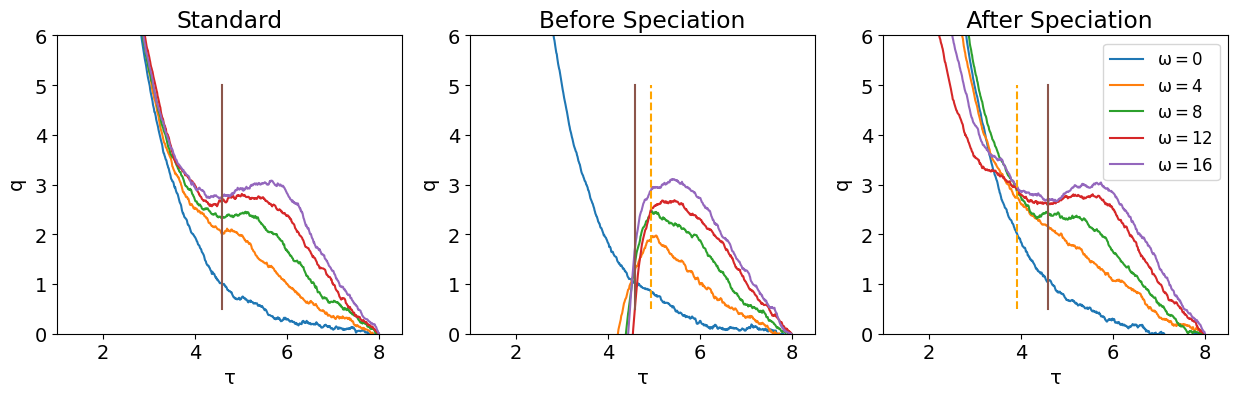

In [226]:
scale = .7
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18*scale, 6*scale))
qav_spec=np.mean(qtraj_spec,axis=1)
qav_early=np.mean(qtraj_early,axis=1)
qav_earliest=np.mean(qtraj_earliest,axis=1)
qav_stand=np.mean(qtraj_stand,axis=1)

# Plot data on each subplot
for iomega in np.arange(nomega):
    ax1.plot(nt*dt-time, qav_stand[iomega,:], label=f'$\omega={4*iomega}$')
    ax2.plot(nt*dt-time, qav_early[iomega,:], label=f'$\omega={4*iomega}$')
    ax3.plot(nt*dt-time, qav_spec[iomega,:], label=f'$\omega={4*iomega}$')
# Add common labels and legend
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('$q$')
    ax.axis([1,8.5,0,6])
    ax.set_title(['Standard', 'Before Speciation', ' After Speciation'][i])
    #plot vertical line
    # ax.vline()
    ax.plot([nt*dt-dt*itfms*[20, 0.9,1.2][i]]*2, [0.5, 5], color='orange', linestyle='--')
    ax.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0.5,5])

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('new_figs/3_3rd_regime.pdf')
plt.show()

# We get there faster? - DONE

In [93]:
from tqdm import tqdm
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
dim=100
sigma2=1
alpha = -0.5

tspec=(1/2)*np.log(dim)
ns=int(tspec/dt)
print("Speciation time is: ", ns)
#ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))
for ijk in tqdm(np.arange(nsample)):
    qinit=init_backward()
    for iomega in np.arange(nomega):
        omega=4*iomega
        omegag[iomega]=omega
        time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)

Speciation time is:  230


100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


In [94]:
def kl_div(sample1, sample2):
    mean1, std1 = np.mean(sample1, axis=0), np.std(sample1, axis=0)
    mean2, std2 = np.mean(sample2, axis=0), np.std(sample2, axis=0)

    var1, var2 = np.power(std1, 2), np.power(std2, 2)
    kl = 0.5 * np.sum(np.power(mean1 - mean2, 2) / var2 +
                         var1 / var2 - 1.0 - np.log10(var1) + np.log10(var2))
    return np.sum(kl)

In [95]:
qref = np.zeros((nsample,nt))
for ijk in tqdm(np.arange(nsample)):
    qinit=init_backward()
    _,qref[ijk,:],_=calc_traj_back_exact(qinit,nt,dt,itfms,omega=0.,sigma2=1., alpha=0.)
qref = qref[:,-1]

 10%|█         | 10/100 [00:00<00:00, 90.76it/s]

100%|██████████| 100/100 [00:01<00:00, 91.46it/s]


In [96]:
print(qtraj[0,:,:].T.shape)
print(qtraj[0,:,:].T[-1,:].mean())
print(kl_div(qtraj[0,:,-1], qtraj[1,:,0]))


(800, 100)
9.729841187806423
39.915121207603896


In [138]:
alphas = [0., -0.5, -0.75]#, 0.25, 0.5, 0.75]
all_qtrajs = []
_, target, _ = calc_traj_back_exact(qinit,nt,dt,itfms,omega=0.,sigma2=1., alpha=0.)
for i, alpha in tqdm(enumerate(alphas)):
    qtraj=np.zeros((nomega,nsample,nt))
    normstat=np.zeros((nomega,nsample,nt))
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],_=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)
    all_qtrajs.append(qtraj)

3it [00:17,  5.78s/it]


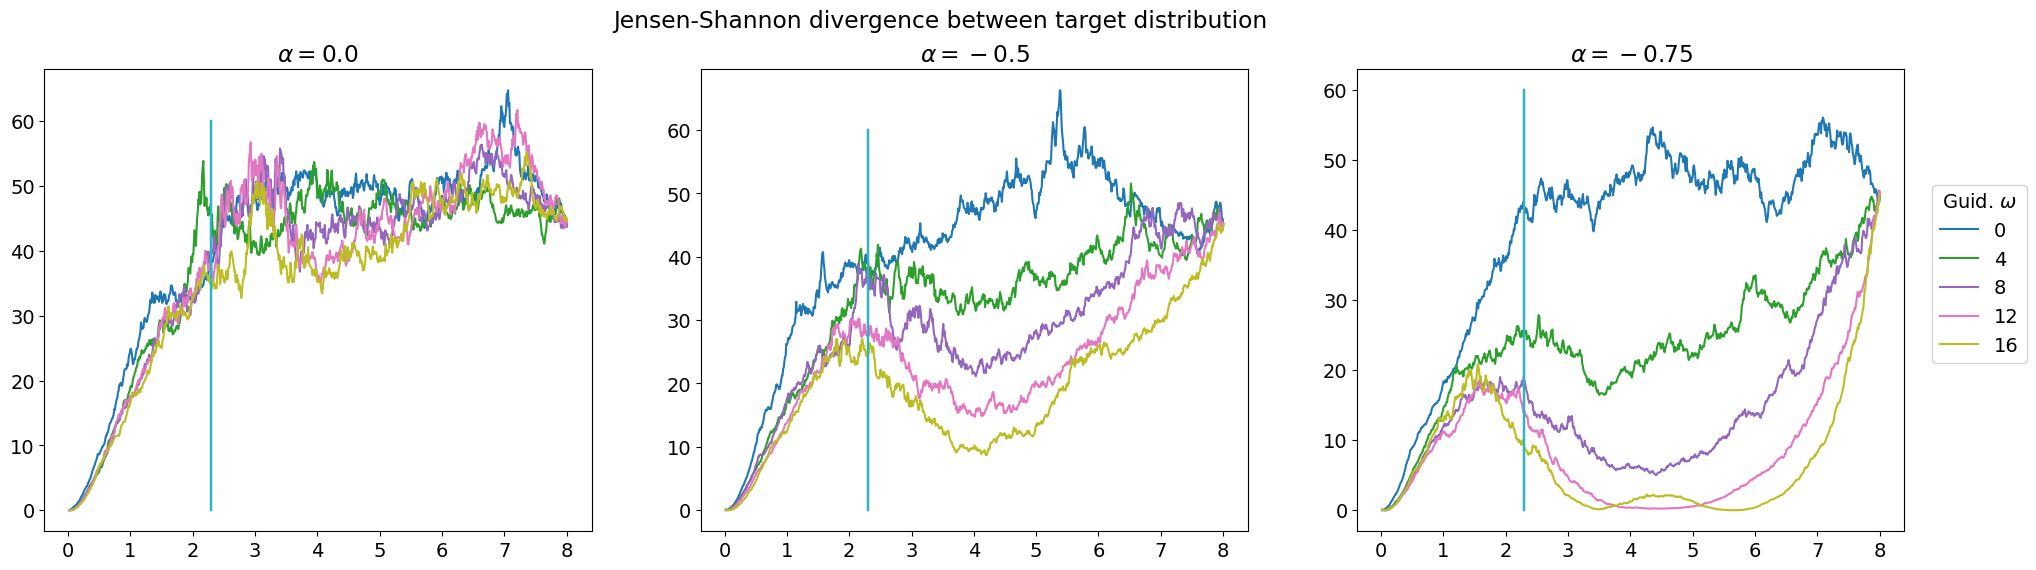

In [136]:
fig, axes = plt.subplots(1, len(alphas), figsize=(24, 6))
for i, (qtr, alpha) in enumerate(zip(all_qtrajs, alphas)):
    for j, qt in enumerate(qtr):
            jss = []
            for samp_t in qt.T:
                kl_for = kl_div(samp_t, qref)
                kl_back = kl_div(qref, samp_t)
                js = 0.5 * kl_for + 0.5 * kl_back
                jss.append(js)
                
            axes[i].plot(nt*dt-time,jss, label=j*4)
            axes[i].set_title(f'$\\alpha={alpha}$')
            axes[i].plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0.,60])
plt.legend(bbox_to_anchor=(1.05, .75), borderaxespad=0., title='Guid. $\omega$')

plt.suptitle('Jensen-Shannon divergence between target distribution ')
plt.tight_layout
plt.show()

# difference in score for dim - DONE

In [227]:
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
sigma2=1

#ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
nomega=1
omegag=np.zeros(nomega)
alpha = 0.
dims = [1,2,5,10,20, 100]
all_normavs = []
for i, dim in tqdm(enumerate(dims)):
    normstat=np.zeros((nomega,nsample,nt))
    tspec=(1/2)*np.log(dim)
    ns=int(tspec/dt)
    print("Speciation time is: ", ns)
    itfms=nt-ns
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=4*(iomega+1)
            omegag[iomega]=omega
            time, _,normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)
    all_normavs.append(np.mean(normstat,axis=1))

0it [00:00, ?it/s]

Speciation time is:  0


1it [00:01,  1.08s/it]

Speciation time is:  34


2it [00:02,  1.09s/it]

Speciation time is:  80


3it [00:03,  1.11s/it]

Speciation time is:  115


4it [00:04,  1.11s/it]

Speciation time is:  149


5it [00:05,  1.10s/it]

Speciation time is:  230


6it [00:06,  1.09s/it]


In [233]:
np.array(all_normavs).shape

(6, 1, 800)

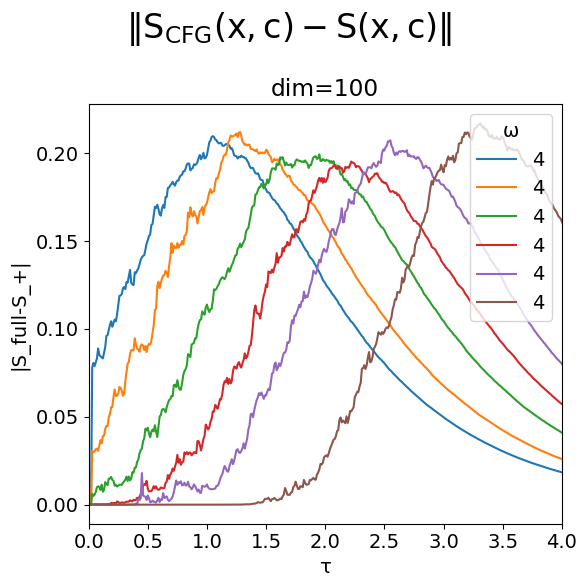

In [236]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
for i, d in enumerate(dims):
        axes.plot(nt*dt-time,all_normavs[i][0,:], label=(1+iomega)*4)
axes.set_xlabel(r'$\tau$')
axes.set_ylabel('|S_full-S_+|')
axes.set_title(f'dim={dims[i]}')
axes.set_xlim(0, 4.)
plt.legend(title='$\omega$', loc='upper right') 

plt.suptitle('$\|S_{CFG}(x,c)-S(x,c)\|$', fontsize=24)
plt.tight_layout()
plt.show()

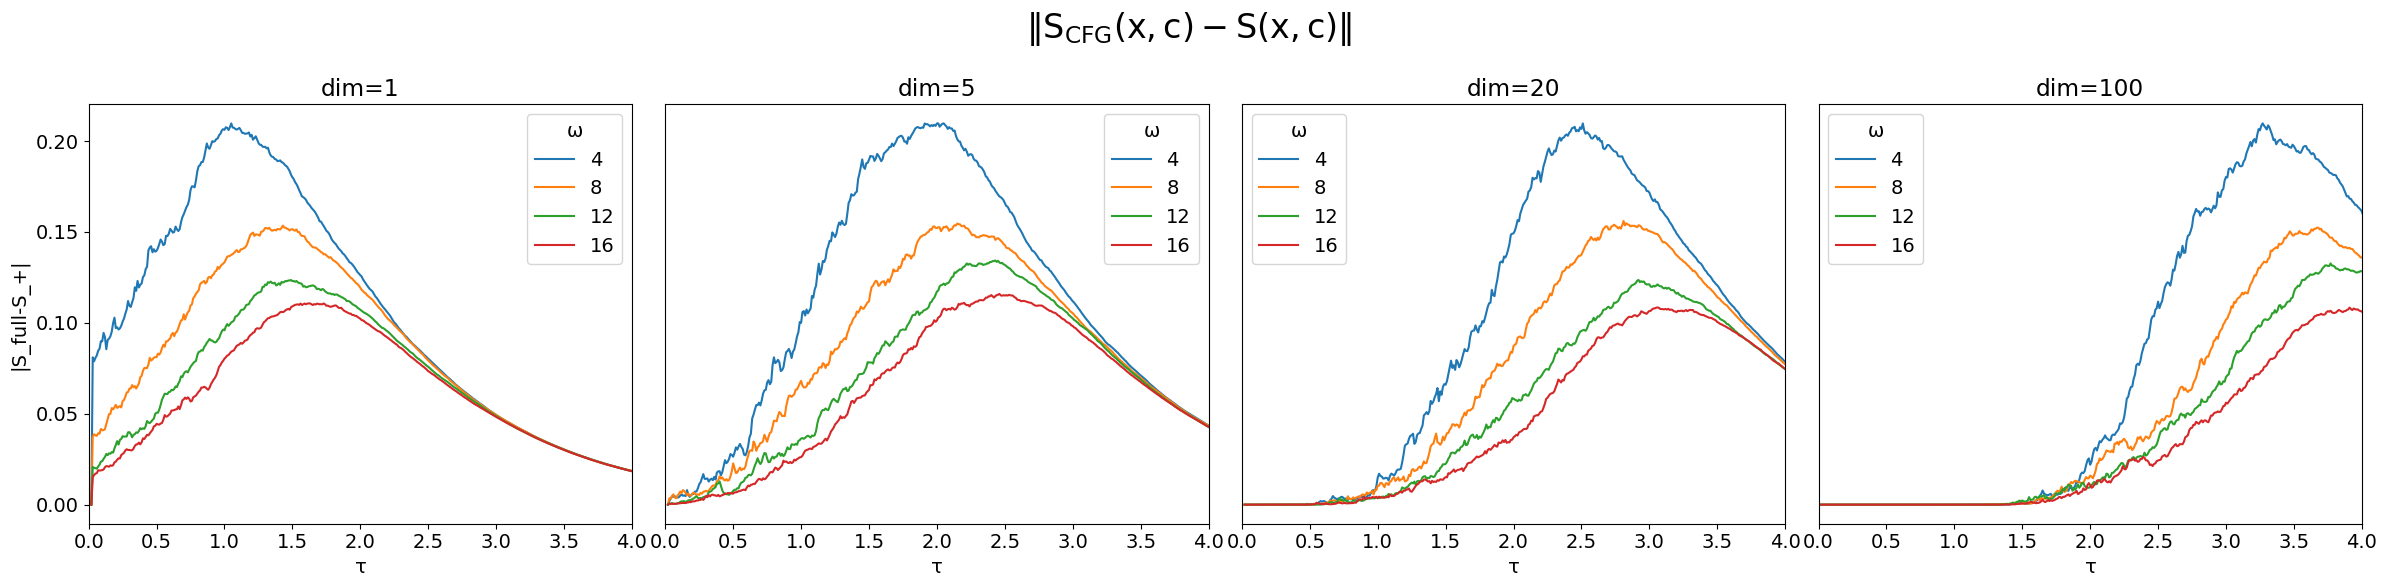

In [200]:
indices = [0,2,4,5]
fig, axes = plt.subplots(1, len(indices), figsize=(24, 6))
for ii, i in enumerate(indices):
    for iomega in np.arange(nomega):
        axes[ii].plot(nt*dt-time,all_normavs[i][iomega,:], label=(1+iomega)*4)
    axes[ii].set_xlabel(r'$\tau$')
    axes[ii].set_ylabel('|S_full-S_+|')
    axes[ii].set_title(f'dim={dims[i]}')
    axes[ii].set_xlim(0, 4.)
    if i>0:
        axes[ii].yaxis.set_visible(False)
    axes[ii].legend(title='$\omega$') 

plt.suptitle('$\|S_{CFG}(x,c)-S(x,c)\|$', fontsize=24)
plt.tight_layout()
plt.show()

# Last plot no wandb  - DONE

In [203]:
from tqdm import tqdm
#Run nsample trajectories 
nsample=100
dt=.01
nt=800 #final time is nt*dt
sigma2=1


nomega=30
all_js = []
dims = [2, 5, 10, 20, 50,  100]
for dim in tqdm(dims):
    tspec=(1/2)*np.log(dim)
    ns=int(tspec/dt)
    itfms=nt-ns

    omegag=np.zeros(nomega)
    qtraj=np.zeros((nomega,nsample,nt))
    normstat=np.zeros((nomega,nsample,nt))
    
    ###
    qref = np.zeros((nsample,nt))
    for ijk in np.arange(nsample):
        qinit=init_backward()
        _,qref[ijk,:],_=calc_traj_back_exact(qinit,nt,dt,itfms,omega=0.,sigma2=1., alpha=0.)
    qref = qref[:,-1]
    ###
    
    for ijk in np.arange(nsample):
        qinit=init_backward()
        for iomega in np.arange(nomega):
            omega=iomega
            omegag[iomega]=omega
            time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2, alpha)

    jss = []
    for j, qt in enumerate(qtraj[:,:,-1]):
        kl_for = kl_div(qt, qref)
        kl_back = kl_div(qref, qt)
        js = 0.5 * kl_for + 0.5 * kl_back
        jss.append(js)
    all_js.append(jss)

100%|██████████| 6/6 [03:29<00:00, 35.00s/it]


In [205]:
np.array(all_js).shape

(6, 30)

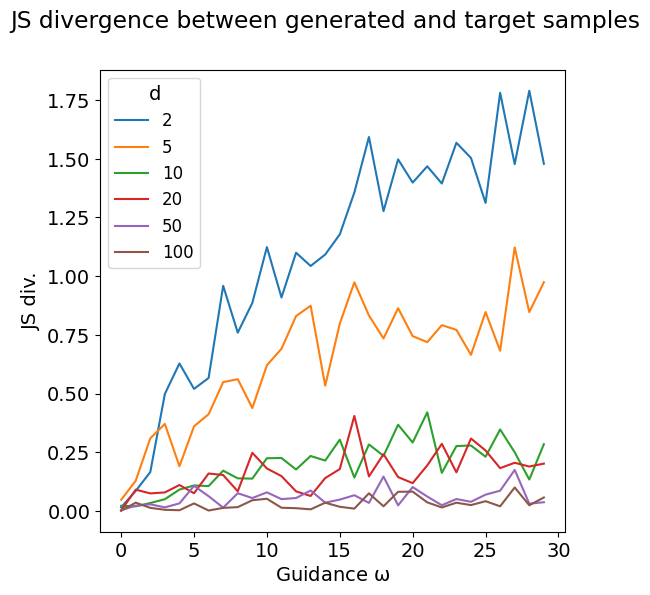

In [207]:
np.array(all_js).shape
plt.plot(np.array(all_js).T, label=dims)
plt.xlabel('Guidance $\omega$')
plt.ylabel('JS div.')
plt.suptitle('JS divergence between generated and target samples')
plt.legend(title='$d$', fontsize=12)
plt.show()

# Techical plot - his